In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

Using TensorFlow backend.


In [4]:
data_df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [5]:
data_df.shape

(284807, 31)

In [6]:
data_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Check for Null Values

In [8]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check for Fraud, Not Fraud transaction ration in given dataset

In [9]:
data_df.Class.value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

There are 99.82% data belongs to not fraud and 0.17% data belong to fraud transaction.

Data is imbanalced

## Distribution of Amount between classes

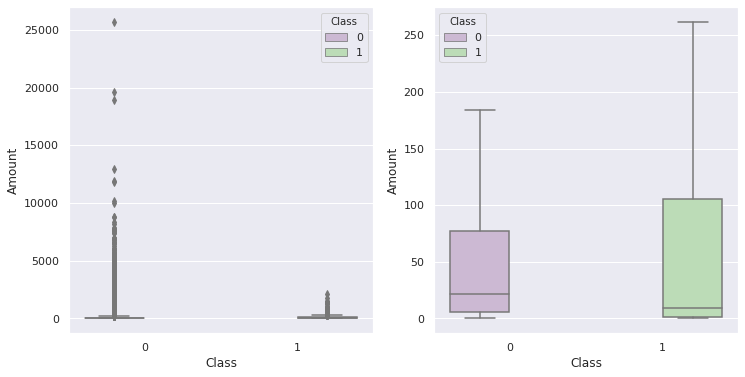

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [32]:
data_df.groupby(['Class'])['Amount'].agg({'min','max','mean','median','std'}).reset_index()

,Class,std,mean,max,min,median
0,0,250.105092,88.291022,25691.16,0.0,22.00
1,1,256.683288,122.211321,2125.87,0.0,9.25


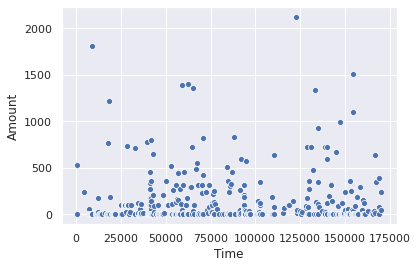

In [33]:
sns.scatterplot(x='Time', y='Amount', data=data_df[data_df['Class'] == 1])
plt.show()

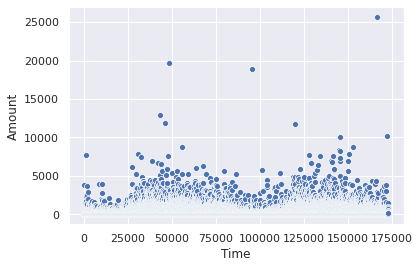

In [34]:
sns.scatterplot(x='Time', y='Amount', data=data_df[data_df['Class'] == 0])
plt.show()

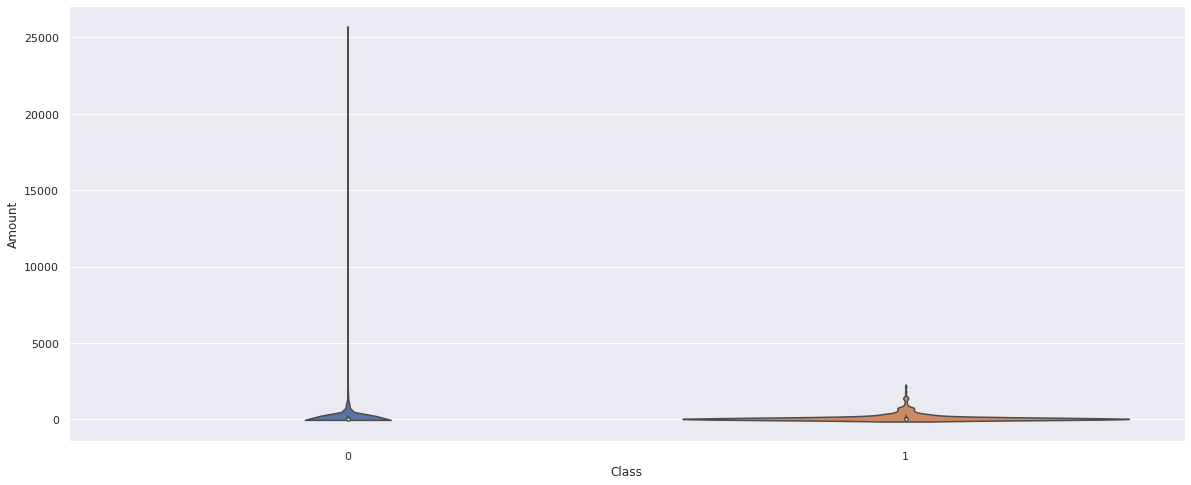

In [37]:
plt.figure(figsize=(20,8))

ax = sns.violinplot(x='Class', y='Amount', data=data_df)

plt.show()

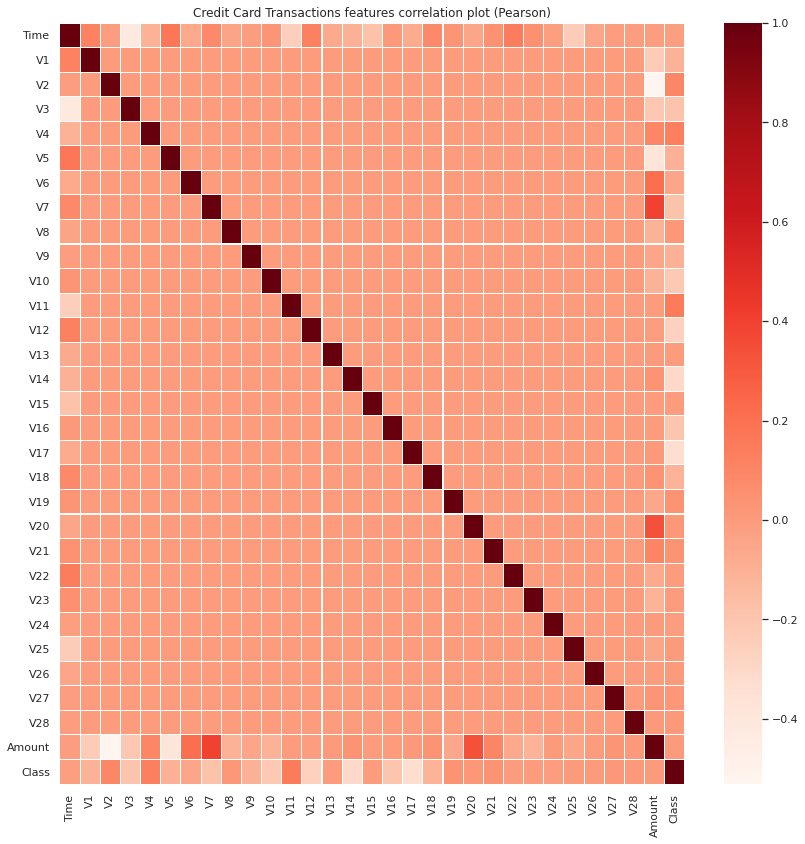

In [38]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

<Figure size 432x288 with 0 Axes>

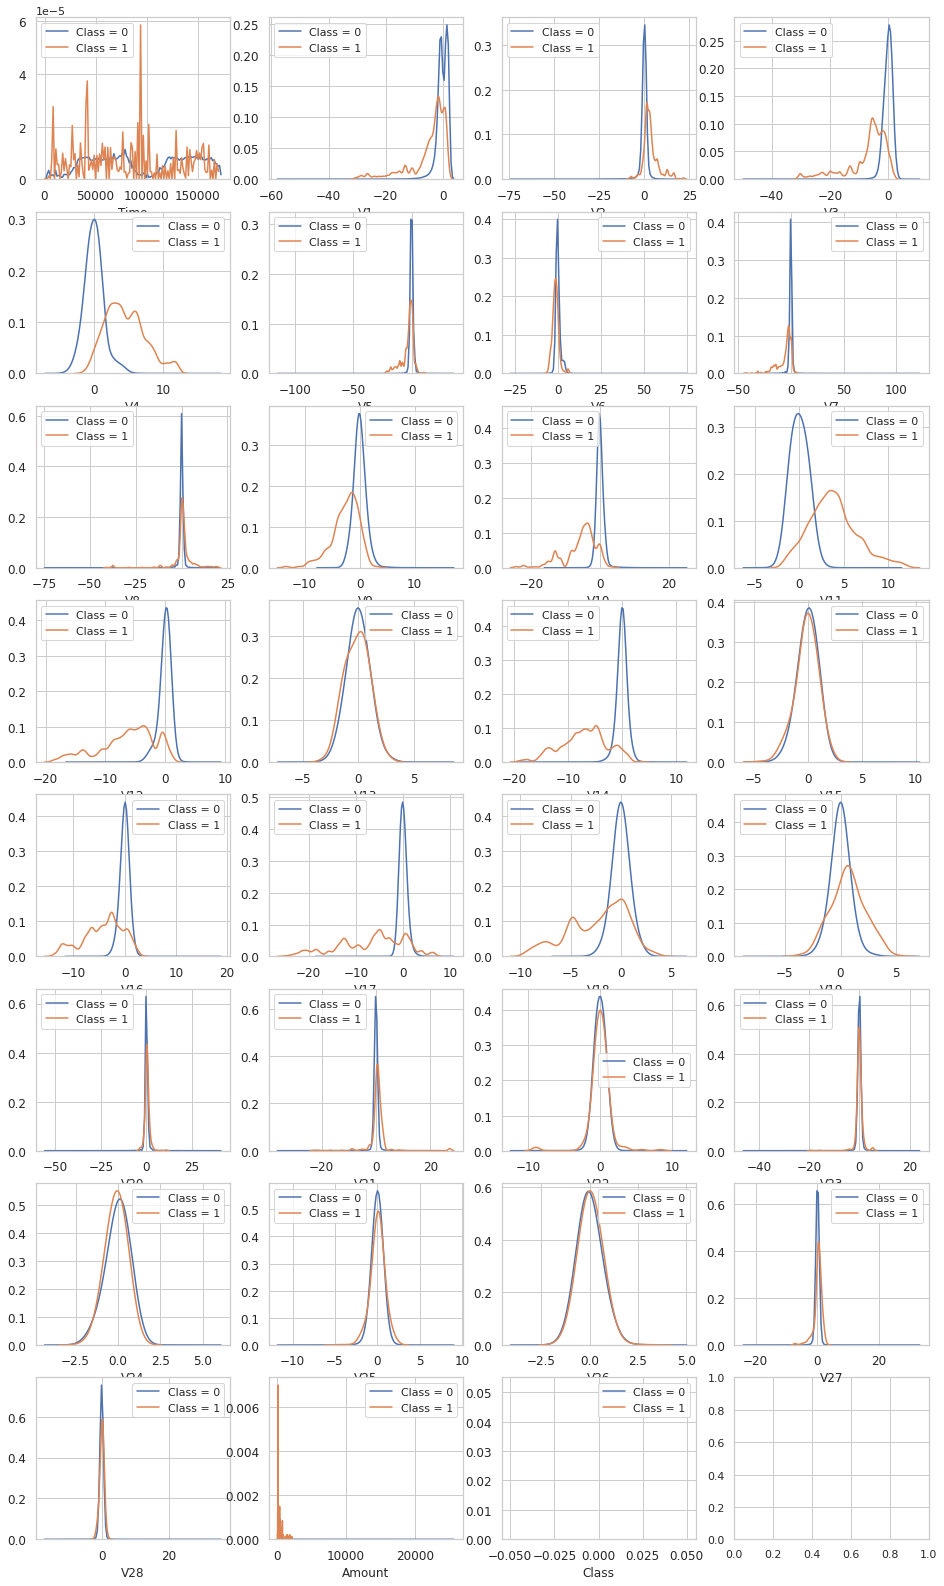

In [39]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [40]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [41]:
X, y = data_df[predictors], data_df[target]
X = np.array(X)
y = np.array(y)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [43]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
def show_model_report(x,y,model):
    y_pred = model.predict(x)

    print('Classification report:')
    print(classification_report(y, y_pred))
    print("-----------------------------------\n")
    print('Confusion Metrix: ')
    print(confusion_matrix(y, y_pred))
    print("-----------------------------------\n")
    print('Accuracy Score')
    print(roc_auc_score(y, y_pred))
    print("-----------------------------------\n")
    
    try:
        y_pred = model.predict_proba(x)[:,1]
        FPR, TPR, threshold = roc_curve(y, y_pred)
        print("ROC AUC Score")
        print(roc_auc_score(y, y_pred))

        #Plot ROC curve
        plt.title('ROC Curve')
        plt.plot(FPR, TPR)
        plt.plot([0,1], ls ='--')
        plt.plot([0,0], [1,0], c='.7'), plt.plot([1,1], c='.7')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    except Exception as ex:
        pass

## Logistic Regression

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       0.90      0.64      0.75       379

    accuracy                           1.00    213605
   macro avg       0.95      0.82      0.87    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213198     28]
 [   135    244]]
-----------------------------------

Accuracy Score
0.8218340781135588
-----------------------------------

ROC AUC Score
0.9801699619962984


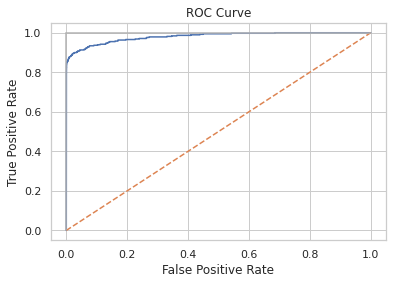

Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.85      0.60      0.70       113

    accuracy                           1.00     71202
   macro avg       0.92      0.80      0.85     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71077    12]
 [   45    68]]
-----------------------------------

Accuracy Score
0.8008005545087008
-----------------------------------

ROC AUC Score
0.9745163018263159


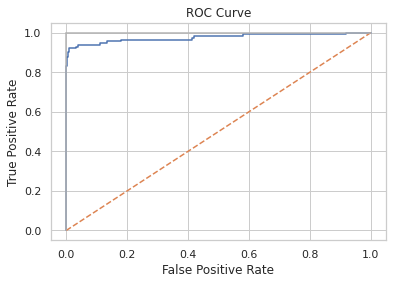

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)

print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## GaussianNB

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213226
           1       0.06      0.83      0.12       379

    accuracy                           0.98    213605
   macro avg       0.53      0.90      0.55    213605
weighted avg       1.00      0.98      0.99    213605

-----------------------------------

Confusion Metrix: 
[[208680   4546]
 [    64    315]]
-----------------------------------

Accuracy Score
0.9049072314838217
-----------------------------------

ROC AUC Score
0.9598116094541334


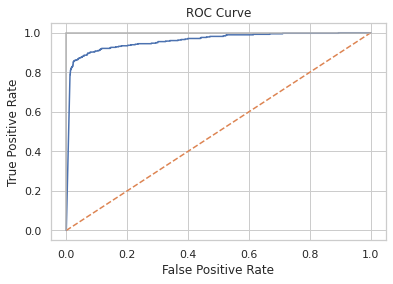




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71089
           1       0.06      0.82      0.11       113

    accuracy                           0.98     71202
   macro avg       0.53      0.90      0.55     71202
weighted avg       1.00      0.98      0.99     71202

-----------------------------------

Confusion Metrix: 
[[69559  1530]
 [   20    93]]
-----------------------------------

Accuracy Score
0.9007432662310251
-----------------------------------

ROC AUC Score
0.9681224719306735


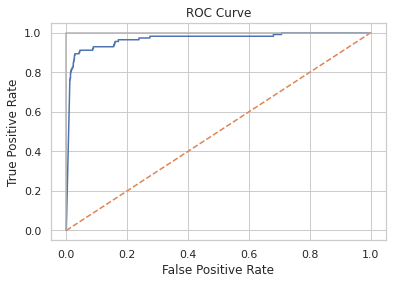

In [46]:
lr_model = GaussianNB()
lr_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## SVC

In [47]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,svc_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,svc_model)




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       0.98      0.82      0.89       379

    accuracy                           1.00    213605
   macro avg       0.99      0.91      0.95    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213220      6]
 [    69    310]]
-----------------------------------

Accuracy Score
0.9089569066745413
-----------------------------------




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.91      0.62      0.74       113

    accuracy                           1.00     71202
   macro avg       0.95      0.81      0.87     71202
weighted avg       1.00      1.00  

## DecisionTree




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       1.00      1.00      1.00       379

    accuracy                           1.00    213605
   macro avg       1.00      1.00      1.00    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213226      0]
 [     0    379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


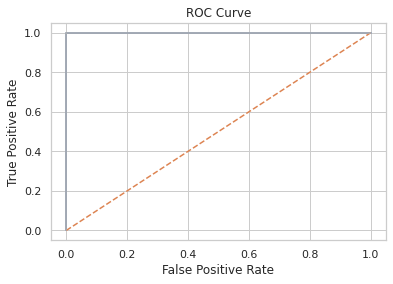




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.75      0.75      0.75       113

    accuracy                           1.00     71202
   macro avg       0.87      0.88      0.87     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71060    29]
 [   28    85]]
-----------------------------------

Accuracy Score
0.8759022250184456
-----------------------------------

ROC AUC Score
0.8759022250184456


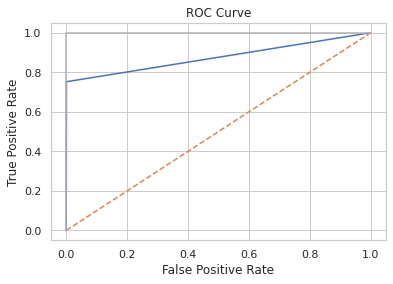

In [50]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,dt_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,dt_model)

## RandomForestClassifier

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       1.00      1.00      1.00       379

    accuracy                           1.00    213605
   macro avg       1.00      1.00      1.00    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213226      0]
 [     0    379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


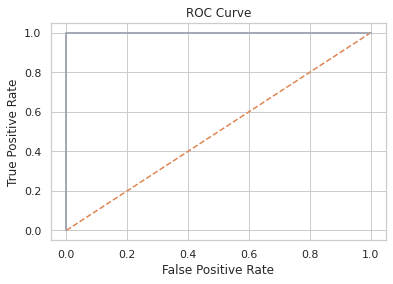




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.95      0.79      0.86       113

    accuracy                           1.00     71202
   macro avg       0.97      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71084     5]
 [   24    89]]
-----------------------------------

Accuracy Score
0.8937701425497169
-----------------------------------

ROC AUC Score
0.9543050049314974


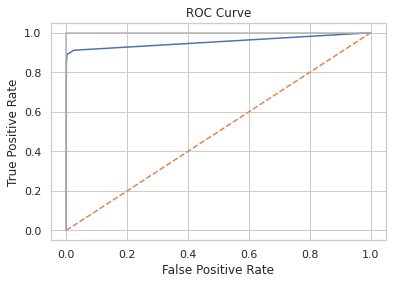

In [51]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,rf_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,rf_model)

## ExtraTreeClassifier

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       1.00      1.00      1.00       379

    accuracy                           1.00    213605
   macro avg       1.00      1.00      1.00    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213226      0]
 [     0    379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


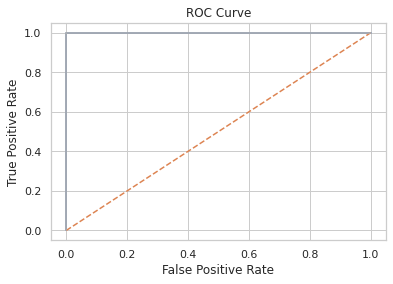




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.65      0.70      0.68       113

    accuracy                           1.00     71202
   macro avg       0.83      0.85      0.84     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71047    42]
 [   34    79]]
-----------------------------------

Accuracy Score
0.849262117771603
-----------------------------------

ROC AUC Score
0.849262117771603


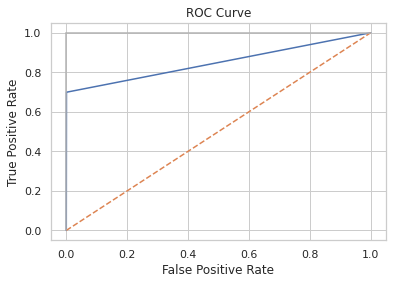

In [48]:
et_model = ExtraTreeClassifier()
et_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,et_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,et_model)

## AdaboostClassifier

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       0.85      0.70      0.77       379

    accuracy                           1.00    213605
   macro avg       0.92      0.85      0.88    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213179     47]
 [   114    265]]
-----------------------------------

Accuracy Score
0.8494940099356222
-----------------------------------

ROC AUC Score
0.998067784037881


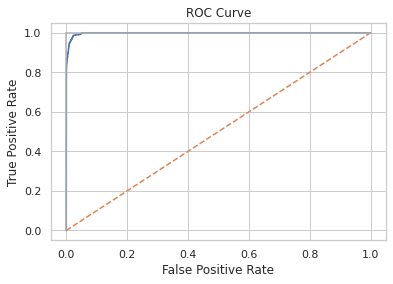




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.81      0.72      0.76       113

    accuracy                           1.00     71202
   macro avg       0.90      0.86      0.88     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71070    19]
 [   32    81]]
-----------------------------------

Accuracy Score
0.8582734443437909
-----------------------------------

ROC AUC Score
0.9844864788087524


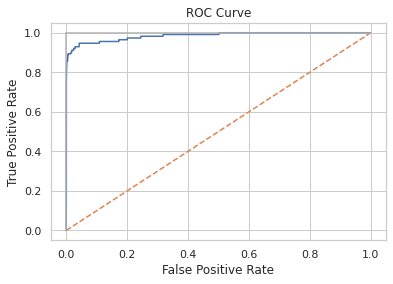

In [52]:
abc_model = AdaBoostClassifier()
abc_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,abc_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,abc_model)

## XGBClassifier

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       1.00      1.00      1.00       379

    accuracy                           1.00    213605
   macro avg       1.00      1.00      1.00    213605
weighted avg       1.00      1.00      1.00    213605

-----------------------------------

Confusion Metrix: 
[[213226      0]
 [     0    379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


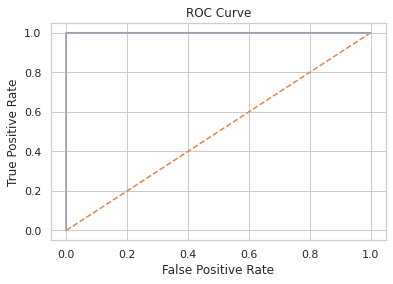




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.97      0.81      0.88       113

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71086     3]
 [   22    91]]
-----------------------------------

Accuracy Score
0.9026337669457593
-----------------------------------

ROC AUC Score
0.9820942388433196


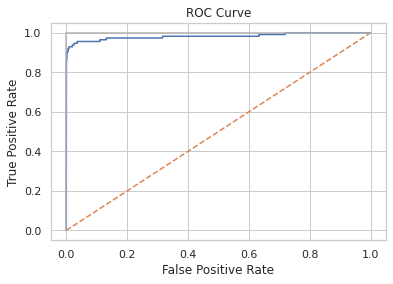

In [53]:
xb_model = XGBClassifier()
xb_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,xb_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,xb_model)

## CatBoostClassifier

Learning rate set to 0.101784
0:	learn: 0.3591973	total: 135ms	remaining: 2m 15s
1:	learn: 0.1833560	total: 200ms	remaining: 1m 39s
2:	learn: 0.0994814	total: 268ms	remaining: 1m 29s
3:	learn: 0.0555281	total: 333ms	remaining: 1m 22s
4:	learn: 0.0325612	total: 394ms	remaining: 1m 18s
5:	learn: 0.0207036	total: 457ms	remaining: 1m 15s
6:	learn: 0.0139640	total: 517ms	remaining: 1m 13s
7:	learn: 0.0101718	total: 580ms	remaining: 1m 11s
8:	learn: 0.0078448	total: 640ms	remaining: 1m 10s
9:	learn: 0.0062734	total: 704ms	remaining: 1m 9s
10:	learn: 0.0052853	total: 768ms	remaining: 1m 9s
11:	learn: 0.0045699	total: 828ms	remaining: 1m 8s
12:	learn: 0.0041087	total: 888ms	remaining: 1m 7s
13:	learn: 0.0037417	total: 949ms	remaining: 1m 6s
14:	learn: 0.0034676	total: 1.01s	remaining: 1m 6s
15:	learn: 0.0032680	total: 1.07s	remaining: 1m 5s
16:	learn: 0.0030997	total: 1.13s	remaining: 1m 5s
17:	learn: 0.0029857	total: 1.19s	remaining: 1m 5s
18:	learn: 0.0028826	total: 1.25s	remaining: 1m 4s
19

164:	learn: 0.0012877	total: 10.2s	remaining: 51.6s
165:	learn: 0.0012825	total: 10.3s	remaining: 51.5s
166:	learn: 0.0012774	total: 10.3s	remaining: 51.5s
167:	learn: 0.0012762	total: 10.4s	remaining: 51.4s
168:	learn: 0.0012720	total: 10.4s	remaining: 51.4s
169:	learn: 0.0012695	total: 10.5s	remaining: 51.3s
170:	learn: 0.0012683	total: 10.6s	remaining: 51.3s
171:	learn: 0.0012654	total: 10.6s	remaining: 51.2s
172:	learn: 0.0012638	total: 10.7s	remaining: 51.1s
173:	learn: 0.0012584	total: 10.8s	remaining: 51s
174:	learn: 0.0012564	total: 10.8s	remaining: 51s
175:	learn: 0.0012535	total: 10.9s	remaining: 50.9s
176:	learn: 0.0012528	total: 10.9s	remaining: 50.8s
177:	learn: 0.0012510	total: 11s	remaining: 50.7s
178:	learn: 0.0012454	total: 11.1s	remaining: 50.7s
179:	learn: 0.0012429	total: 11.1s	remaining: 50.6s
180:	learn: 0.0012403	total: 11.2s	remaining: 50.6s
181:	learn: 0.0012352	total: 11.2s	remaining: 50.5s
182:	learn: 0.0012331	total: 11.3s	remaining: 50.4s
183:	learn: 0.0012

323:	learn: 0.0008490	total: 20s	remaining: 41.6s
324:	learn: 0.0008425	total: 20s	remaining: 41.6s
325:	learn: 0.0008414	total: 20.1s	remaining: 41.5s
326:	learn: 0.0008388	total: 20.1s	remaining: 41.5s
327:	learn: 0.0008378	total: 20.2s	remaining: 41.4s
328:	learn: 0.0008362	total: 20.3s	remaining: 41.3s
329:	learn: 0.0008342	total: 20.3s	remaining: 41.3s
330:	learn: 0.0008334	total: 20.4s	remaining: 41.2s
331:	learn: 0.0008317	total: 20.4s	remaining: 41.1s
332:	learn: 0.0008293	total: 20.5s	remaining: 41.1s
333:	learn: 0.0008286	total: 20.6s	remaining: 41s
334:	learn: 0.0008268	total: 20.6s	remaining: 41s
335:	learn: 0.0008261	total: 20.7s	remaining: 40.9s
336:	learn: 0.0008251	total: 20.8s	remaining: 40.8s
337:	learn: 0.0008213	total: 20.8s	remaining: 40.8s
338:	learn: 0.0008182	total: 20.9s	remaining: 40.7s
339:	learn: 0.0008155	total: 20.9s	remaining: 40.6s
340:	learn: 0.0008125	total: 21s	remaining: 40.6s
341:	learn: 0.0008102	total: 21.1s	remaining: 40.5s
342:	learn: 0.0008081	

484:	learn: 0.0004976	total: 30s	remaining: 31.9s
485:	learn: 0.0004968	total: 30.1s	remaining: 31.8s
486:	learn: 0.0004950	total: 30.1s	remaining: 31.8s
487:	learn: 0.0004948	total: 30.2s	remaining: 31.7s
488:	learn: 0.0004936	total: 30.3s	remaining: 31.6s
489:	learn: 0.0004906	total: 30.3s	remaining: 31.6s
490:	learn: 0.0004901	total: 30.4s	remaining: 31.5s
491:	learn: 0.0004825	total: 30.5s	remaining: 31.4s
492:	learn: 0.0004806	total: 30.5s	remaining: 31.4s
493:	learn: 0.0004794	total: 30.6s	remaining: 31.3s
494:	learn: 0.0004767	total: 30.6s	remaining: 31.3s
495:	learn: 0.0004739	total: 30.7s	remaining: 31.2s
496:	learn: 0.0004689	total: 30.8s	remaining: 31.1s
497:	learn: 0.0004666	total: 30.8s	remaining: 31.1s
498:	learn: 0.0004645	total: 30.9s	remaining: 31s
499:	learn: 0.0004611	total: 30.9s	remaining: 30.9s
500:	learn: 0.0004578	total: 31s	remaining: 30.9s
501:	learn: 0.0004564	total: 31.1s	remaining: 30.8s
502:	learn: 0.0004553	total: 31.1s	remaining: 30.8s
503:	learn: 0.0004

645:	learn: 0.0002681	total: 40.5s	remaining: 22.2s
646:	learn: 0.0002669	total: 40.5s	remaining: 22.1s
647:	learn: 0.0002658	total: 40.6s	remaining: 22.1s
648:	learn: 0.0002654	total: 40.7s	remaining: 22s
649:	learn: 0.0002631	total: 40.8s	remaining: 22s
650:	learn: 0.0002625	total: 40.9s	remaining: 21.9s
651:	learn: 0.0002615	total: 40.9s	remaining: 21.8s
652:	learn: 0.0002596	total: 41s	remaining: 21.8s
653:	learn: 0.0002592	total: 41s	remaining: 21.7s
654:	learn: 0.0002590	total: 41.1s	remaining: 21.7s
655:	learn: 0.0002559	total: 41.2s	remaining: 21.6s
656:	learn: 0.0002543	total: 41.2s	remaining: 21.5s
657:	learn: 0.0002541	total: 41.3s	remaining: 21.5s
658:	learn: 0.0002520	total: 41.4s	remaining: 21.4s
659:	learn: 0.0002519	total: 41.4s	remaining: 21.3s
660:	learn: 0.0002510	total: 41.5s	remaining: 21.3s
661:	learn: 0.0002507	total: 41.5s	remaining: 21.2s
662:	learn: 0.0002506	total: 41.6s	remaining: 21.1s
663:	learn: 0.0002475	total: 41.7s	remaining: 21.1s
664:	learn: 0.000245

806:	learn: 0.0001719	total: 50.7s	remaining: 12.1s
807:	learn: 0.0001718	total: 50.7s	remaining: 12.1s
808:	learn: 0.0001714	total: 50.8s	remaining: 12s
809:	learn: 0.0001705	total: 50.9s	remaining: 11.9s
810:	learn: 0.0001705	total: 50.9s	remaining: 11.9s
811:	learn: 0.0001697	total: 51s	remaining: 11.8s
812:	learn: 0.0001695	total: 51s	remaining: 11.7s
813:	learn: 0.0001692	total: 51.1s	remaining: 11.7s
814:	learn: 0.0001690	total: 51.2s	remaining: 11.6s
815:	learn: 0.0001689	total: 51.2s	remaining: 11.6s
816:	learn: 0.0001680	total: 51.3s	remaining: 11.5s
817:	learn: 0.0001679	total: 51.4s	remaining: 11.4s
818:	learn: 0.0001673	total: 51.4s	remaining: 11.4s
819:	learn: 0.0001672	total: 51.5s	remaining: 11.3s
820:	learn: 0.0001667	total: 51.5s	remaining: 11.2s
821:	learn: 0.0001666	total: 51.6s	remaining: 11.2s
822:	learn: 0.0001657	total: 51.7s	remaining: 11.1s
823:	learn: 0.0001650	total: 51.7s	remaining: 11s
824:	learn: 0.0001642	total: 51.8s	remaining: 11s
825:	learn: 0.0001634	

967:	learn: 0.0001192	total: 1m	remaining: 2.01s
968:	learn: 0.0001189	total: 1m	remaining: 1.95s
969:	learn: 0.0001183	total: 1m	remaining: 1.89s
970:	learn: 0.0001182	total: 1m 1s	remaining: 1.82s
971:	learn: 0.0001182	total: 1m 1s	remaining: 1.76s
972:	learn: 0.0001181	total: 1m 1s	remaining: 1.7s
973:	learn: 0.0001180	total: 1m 1s	remaining: 1.63s
974:	learn: 0.0001180	total: 1m 1s	remaining: 1.57s
975:	learn: 0.0001179	total: 1m 1s	remaining: 1.51s
976:	learn: 0.0001177	total: 1m 1s	remaining: 1.44s
977:	learn: 0.0001175	total: 1m 1s	remaining: 1.38s
978:	learn: 0.0001173	total: 1m 1s	remaining: 1.32s
979:	learn: 0.0001172	total: 1m 1s	remaining: 1.26s
980:	learn: 0.0001168	total: 1m 1s	remaining: 1.19s
981:	learn: 0.0001166	total: 1m 1s	remaining: 1.13s
982:	learn: 0.0001165	total: 1m 1s	remaining: 1.07s
983:	learn: 0.0001164	total: 1m 1s	remaining: 1s
984:	learn: 0.0001159	total: 1m 1s	remaining: 942ms
985:	learn: 0.0001156	total: 1m 1s	remaining: 879ms
986:	learn: 0.0001155	tot

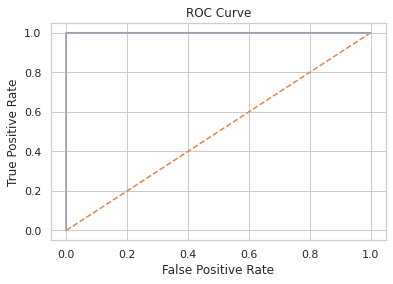




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.93      0.80      0.86       113

    accuracy                           1.00     71202
   macro avg       0.96      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202

-----------------------------------

Confusion Metrix: 
[[71082     7]
 [   23    90]]
-----------------------------------

Accuracy Score
0.89818085443686
-----------------------------------

ROC AUC Score
0.9884544576242893


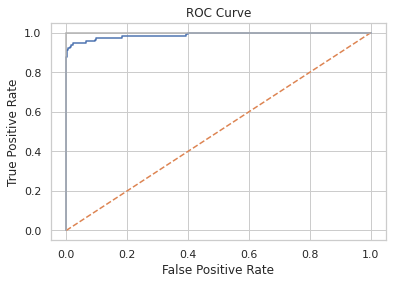

In [54]:
cb_model = CatBoostClassifier()
cb_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,cb_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,cb_model)

## LGBMClassifier

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213226
           1       0.17      0.56      0.26       379

    accuracy                           0.99    213605
   macro avg       0.59      0.78      0.63    213605
weighted avg       1.00      0.99      1.00    213605

-----------------------------------

Confusion Metrix: 
[[212193   1033]
 [   166    213]]
-----------------------------------

Accuracy Score
0.778580326046463
-----------------------------------

ROC AUC Score
0.7039829678159066


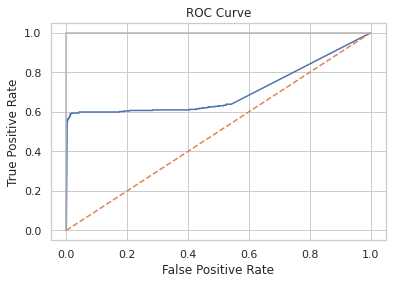




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71089
           1       0.14      0.58      0.22       113

    accuracy                           0.99     71202
   macro avg       0.57      0.79      0.61     71202
weighted avg       1.00      0.99      1.00     71202

-----------------------------------

Confusion Metrix: 
[[70676   413]
 [   47    66]]
-----------------------------------

Accuracy Score
0.7891305887658958
-----------------------------------

ROC AUC Score
0.7020972215185328


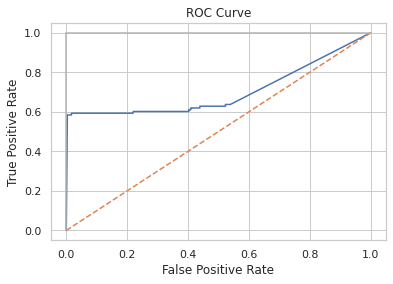

In [55]:
lgbc_model = LGBMClassifier()
lgbc_model.fit(X_train, y_train)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lgbc_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lgbc_model)

## Let's Try Undersampling

In [56]:
nm = NearMiss()
X_us, y_us= nm.fit_sample(X_train,y_train)

In [57]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Undersampled dataset shape {}' .format(Counter(y_us)))

Original dataset shape Counter({0: 213226, 1: 379})
Undersampled dataset shape Counter({0: 379, 1: 379})


## Logistic Regression

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       379
           1       0.98      0.95      0.96       379

    accuracy                           0.96       758
   macro avg       0.96      0.96      0.96       758
weighted avg       0.96      0.96      0.96       758

-----------------------------------

Confusion Metrix: 
[[370   9]
 [ 19 360]]
-----------------------------------

Accuracy Score
0.9630606860158312
-----------------------------------

ROC AUC Score
0.9894737574926379


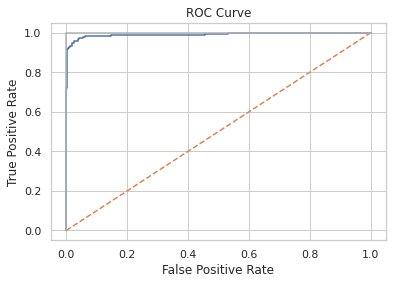

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.63      0.77    213226
           1       0.00      0.95      0.01       379

    accuracy                           0.63    213605
   macro avg       0.50      0.79      0.39    213605
weighted avg       1.00      0.63      0.77    213605

-----------------------------------

Confusion Metrix: 
[[134508  78718]
 [    19    360]]
-----------------------------------

Accuracy Score
0.7903458535095259
-----------------------------------

ROC AUC Score
0.9271498743253749


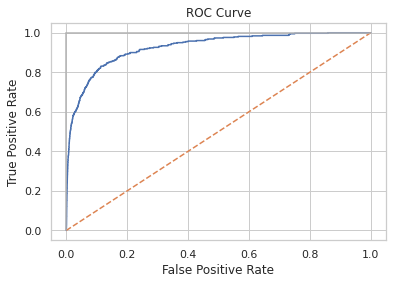

Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.63      0.77     71089
           1       0.00      0.91      0.01       113

    accuracy                           0.63     71202
   macro avg       0.50      0.77      0.39     71202
weighted avg       1.00      0.63      0.77     71202

-----------------------------------

Confusion Metrix: 
[[44824 26265]
 [   10   103]]
-----------------------------------

Accuracy Score
0.7710189906532469
-----------------------------------

ROC AUC Score
0.9062967560170431


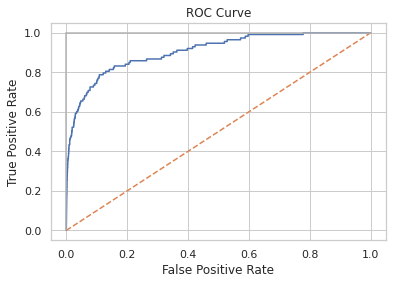

In [58]:
lr_model = LogisticRegression()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)

print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## GaussianNB

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       379
           1       0.99      0.93      0.96       379

    accuracy                           0.96       758
   macro avg       0.96      0.96      0.96       758
weighted avg       0.96      0.96      0.96       758

-----------------------------------

Confusion Metrix: 
[[376   3]
 [ 27 352]]
-----------------------------------

Accuracy Score
0.9604221635883905
-----------------------------------

ROC AUC Score
0.9915170459687693


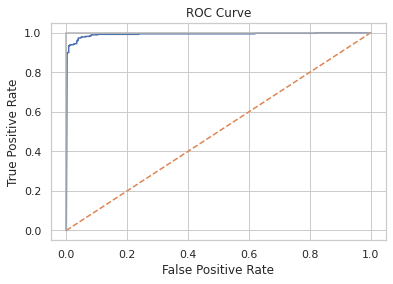




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69    213226
           1       0.00      0.93      0.01       379

    accuracy                           0.53    213605
   macro avg       0.50      0.73      0.35    213605
weighted avg       1.00      0.53      0.69    213605

-----------------------------------

Confusion Metrix: 
[[112344 100882]
 [    27    352]]
-----------------------------------

Accuracy Score
0.7278187398720997
-----------------------------------

ROC AUC Score
0.8140202461362054


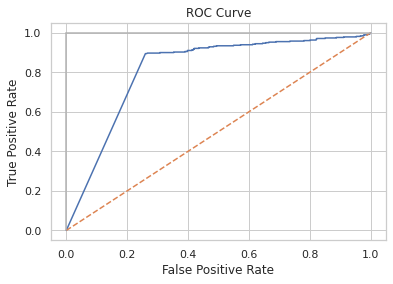




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     71089
           1       0.00      0.95      0.01       113

    accuracy                           0.53     71202
   macro avg       0.50      0.74      0.35     71202
weighted avg       1.00      0.53      0.69     71202

-----------------------------------

Confusion Metrix: 
[[37559 33530]
 [    6   107]]
-----------------------------------

Accuracy Score
0.7376201861881473
-----------------------------------

ROC AUC Score
0.8258631178640957


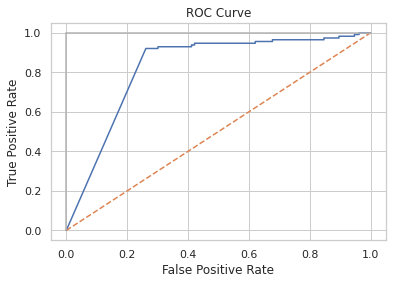

In [59]:
lr_model = GaussianNB()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## SVC

In [60]:
lr_model = SVC()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       379
           1       0.99      0.91      0.95       379

    accuracy                           0.95       758
   macro avg       0.95      0.95      0.95       758
weighted avg       0.95      0.95      0.95       758

-----------------------------------

Confusion Metrix: 
[[375   4]
 [ 35 344]]
-----------------------------------

Accuracy Score
0.9485488126649075
-----------------------------------




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    213226
           1       0.01      0.91      0.02       379

    accuracy                           0.87    213605
   macro avg       0.51      0.89      0.48    213605
weighted avg       1.00      0.87      0.93

## DecisionTree

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


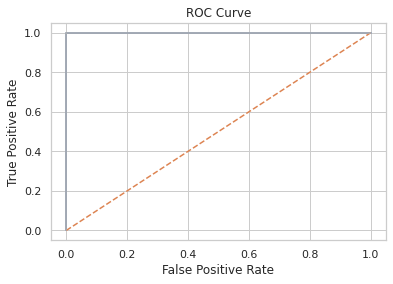




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.15    213605
   macro avg       0.50      0.57      0.13    213605
weighted avg       1.00      0.15      0.26    213605

-----------------------------------

Confusion Metrix: 
[[ 31472 181754]
 [     0    379]]
-----------------------------------

Accuracy Score
0.5737996304390647
-----------------------------------

ROC AUC Score
0.5737996304390647


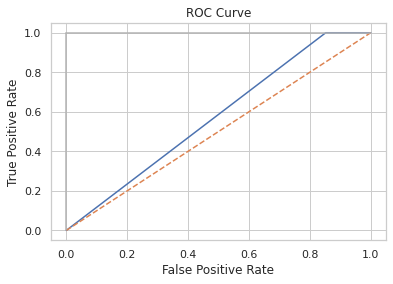




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26     71089
           1       0.00      0.96      0.00       113

    accuracy                           0.15     71202
   macro avg       0.50      0.55      0.13     71202
weighted avg       1.00      0.15      0.26     71202

-----------------------------------

Confusion Metrix: 
[[10713 60376]
 [    5   108]]
-----------------------------------

Accuracy Score
0.5532253163397198
-----------------------------------

ROC AUC Score
0.5532253163397198


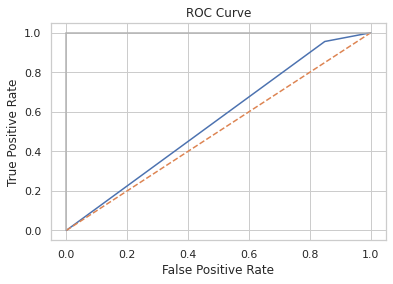

In [61]:
lr_model = DecisionTreeClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## RandomForestClassifier

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


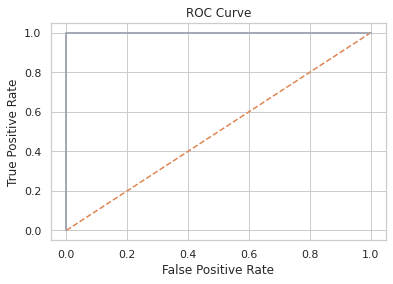




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.07    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.04    213605
   macro avg       0.50      0.52      0.04    213605
weighted avg       1.00      0.04      0.07    213605

-----------------------------------

Confusion Metrix: 
[[  7934 205292]
 [     0    379]]
-----------------------------------

Accuracy Score
0.5186046729760911
-----------------------------------

ROC AUC Score
0.9593451478527113


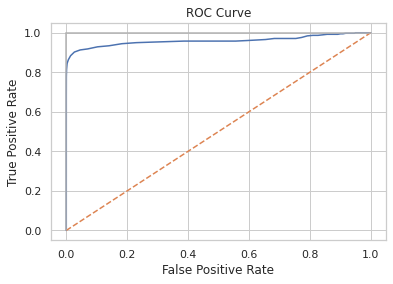




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.07     71089
           1       0.00      0.98      0.00       113

    accuracy                           0.04     71202
   macro avg       0.50      0.51      0.04     71202
weighted avg       1.00      0.04      0.07     71202

-----------------------------------

Confusion Metrix: 
[[ 2664 68425]
 [    2   111]]
-----------------------------------

Accuracy Score
0.5098875185374634
-----------------------------------

ROC AUC Score
0.928782342761915


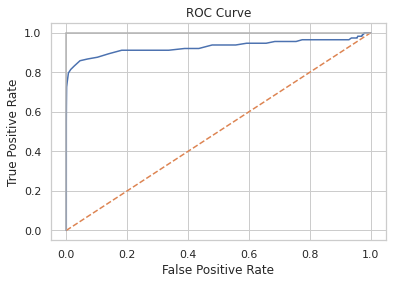

In [62]:
lr_model = RandomForestClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## ExtraTreeClassifier

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


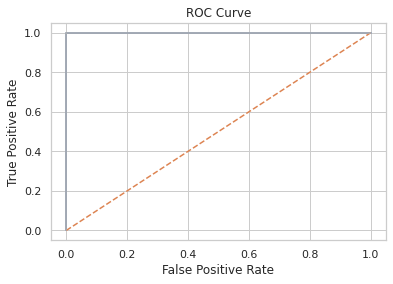




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.15    213605
   macro avg       0.50      0.57      0.13    213605
weighted avg       1.00      0.15      0.26    213605

-----------------------------------

Confusion Metrix: 
[[ 31330 181896]
 [     0    379]]
-----------------------------------

Accuracy Score
0.5734666504084868
-----------------------------------

ROC AUC Score
0.5734666504084868


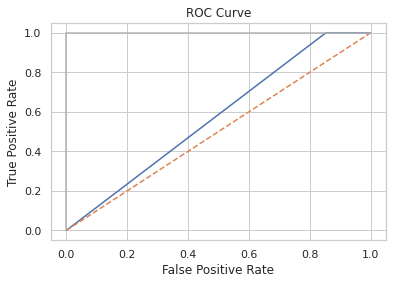




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.25     71089
           1       0.00      0.97      0.00       113

    accuracy                           0.15     71202
   macro avg       0.50      0.56      0.13     71202
weighted avg       1.00      0.15      0.25     71202

-----------------------------------

Confusion Metrix: 
[[10326 60763]
 [    3   110]]
-----------------------------------

Accuracy Score
0.5593529337585927
-----------------------------------

ROC AUC Score
0.5593529337585927


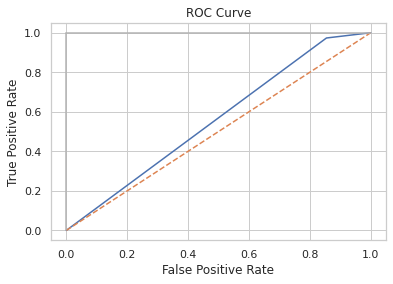

In [63]:
lr_model = ExtraTreeClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## AdaboostClassifier

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


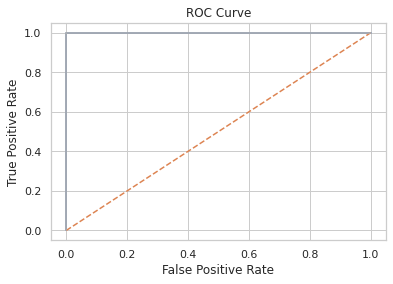




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.37    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.23    213605
   macro avg       0.50      0.61      0.19    213605
weighted avg       1.00      0.23      0.37    213605

-----------------------------------

Confusion Metrix: 
[[ 48119 165107]
 [     0    379]]
-----------------------------------

Accuracy Score
0.6128356766998396
-----------------------------------

ROC AUC Score
0.7941212956574845


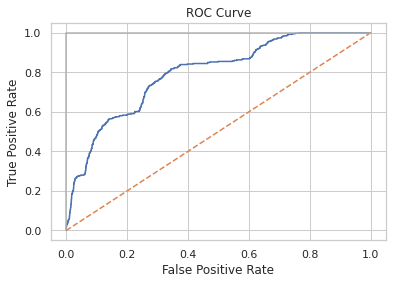




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.37     71089
           1       0.00      0.96      0.00       113

    accuracy                           0.23     71202
   macro avg       0.50      0.59      0.19     71202
weighted avg       1.00      0.23      0.37     71202

-----------------------------------

Confusion Metrix: 
[[16269 54820]
 [    5   108]]
-----------------------------------

Accuracy Score
0.5923030920856158
-----------------------------------

ROC AUC Score
0.7664381691801764


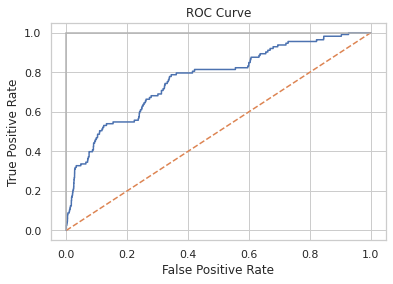

In [64]:
lr_model = AdaBoostClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## XGBClassifier

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


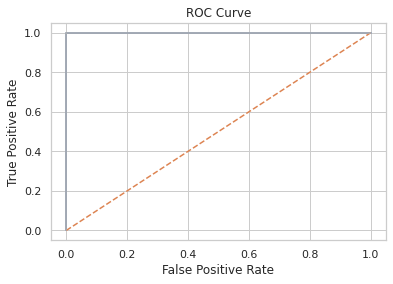




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.13    213605
   macro avg       0.50      0.56      0.11    213605
weighted avg       1.00      0.13      0.22    213605

-----------------------------------

Confusion Metrix: 
[[ 26502 186724]
 [     0    379]]
-----------------------------------

Accuracy Score
0.5621453293688388
-----------------------------------

ROC AUC Score
0.9493796664566914


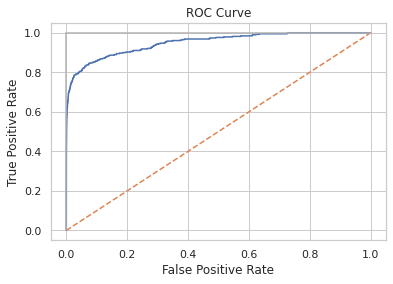




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22     71089
           1       0.00      0.97      0.00       113

    accuracy                           0.13     71202
   macro avg       0.50      0.55      0.11     71202
weighted avg       1.00      0.13      0.22     71202

-----------------------------------

Confusion Metrix: 
[[ 8857 62232]
 [    3   110]]
-----------------------------------

Accuracy Score
0.5490208148653745
-----------------------------------

ROC AUC Score
0.9137292315988795


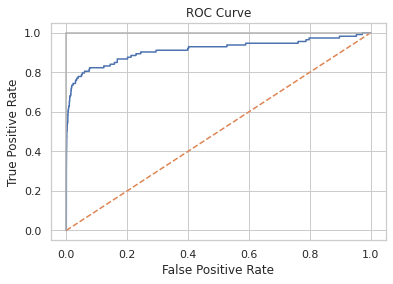

In [65]:
lr_model = XGBClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## CatBoostClassifier

Learning rate set to 0.009153
0:	learn: 0.6786994	total: 5.62ms	remaining: 5.61s
1:	learn: 0.6634601	total: 10.4ms	remaining: 5.17s
2:	learn: 0.6479868	total: 14.9ms	remaining: 4.95s
3:	learn: 0.6347444	total: 19.6ms	remaining: 4.89s
4:	learn: 0.6205968	total: 24.5ms	remaining: 4.88s
5:	learn: 0.6090176	total: 29.3ms	remaining: 4.85s
6:	learn: 0.5959262	total: 34ms	remaining: 4.83s
7:	learn: 0.5814393	total: 38.6ms	remaining: 4.79s
8:	learn: 0.5711636	total: 43.4ms	remaining: 4.78s
9:	learn: 0.5590899	total: 47.9ms	remaining: 4.74s
10:	learn: 0.5466543	total: 52.6ms	remaining: 4.73s
11:	learn: 0.5360092	total: 57.2ms	remaining: 4.71s
12:	learn: 0.5241780	total: 61.9ms	remaining: 4.7s
13:	learn: 0.5131988	total: 66.7ms	remaining: 4.7s
14:	learn: 0.5022332	total: 71.5ms	remaining: 4.69s
15:	learn: 0.4934656	total: 76.2ms	remaining: 4.69s
16:	learn: 0.4826407	total: 81ms	remaining: 4.69s
17:	learn: 0.4727010	total: 85.6ms	remaining: 4.67s
18:	learn: 0.4632447	total: 90.3ms	remaining: 4.66

162:	learn: 0.0880154	total: 780ms	remaining: 4.01s
163:	learn: 0.0874050	total: 786ms	remaining: 4s
164:	learn: 0.0867480	total: 790ms	remaining: 4s
165:	learn: 0.0862339	total: 795ms	remaining: 3.99s
166:	learn: 0.0857561	total: 800ms	remaining: 3.99s
167:	learn: 0.0851760	total: 804ms	remaining: 3.98s
168:	learn: 0.0847412	total: 809ms	remaining: 3.98s
169:	learn: 0.0843341	total: 814ms	remaining: 3.97s
170:	learn: 0.0839279	total: 818ms	remaining: 3.97s
171:	learn: 0.0834785	total: 823ms	remaining: 3.96s
172:	learn: 0.0830363	total: 827ms	remaining: 3.96s
173:	learn: 0.0825532	total: 832ms	remaining: 3.95s
174:	learn: 0.0822226	total: 836ms	remaining: 3.94s
175:	learn: 0.0817409	total: 841ms	remaining: 3.94s
176:	learn: 0.0813387	total: 845ms	remaining: 3.93s
177:	learn: 0.0809696	total: 850ms	remaining: 3.92s
178:	learn: 0.0805278	total: 855ms	remaining: 3.92s
179:	learn: 0.0801263	total: 859ms	remaining: 3.91s
180:	learn: 0.0797184	total: 864ms	remaining: 3.91s
181:	learn: 0.0793

322:	learn: 0.0502337	total: 1.57s	remaining: 3.29s
323:	learn: 0.0501355	total: 1.57s	remaining: 3.28s
324:	learn: 0.0499575	total: 1.58s	remaining: 3.28s
325:	learn: 0.0497828	total: 1.58s	remaining: 3.27s
326:	learn: 0.0496477	total: 1.59s	remaining: 3.27s
327:	learn: 0.0495358	total: 1.59s	remaining: 3.26s
328:	learn: 0.0494861	total: 1.59s	remaining: 3.25s
329:	learn: 0.0493632	total: 1.6s	remaining: 3.25s
330:	learn: 0.0492684	total: 1.6s	remaining: 3.24s
331:	learn: 0.0491857	total: 1.61s	remaining: 3.24s
332:	learn: 0.0491051	total: 1.61s	remaining: 3.23s
333:	learn: 0.0489913	total: 1.62s	remaining: 3.23s
334:	learn: 0.0488734	total: 1.62s	remaining: 3.22s
335:	learn: 0.0487741	total: 1.63s	remaining: 3.22s
336:	learn: 0.0486936	total: 1.63s	remaining: 3.21s
337:	learn: 0.0485995	total: 1.64s	remaining: 3.2s
338:	learn: 0.0484786	total: 1.64s	remaining: 3.2s
339:	learn: 0.0483707	total: 1.65s	remaining: 3.19s
340:	learn: 0.0483005	total: 1.65s	remaining: 3.19s
341:	learn: 0.04

491:	learn: 0.0358149	total: 2.35s	remaining: 2.43s
492:	learn: 0.0357527	total: 2.36s	remaining: 2.43s
493:	learn: 0.0356550	total: 2.36s	remaining: 2.42s
494:	learn: 0.0355647	total: 2.37s	remaining: 2.42s
495:	learn: 0.0355037	total: 2.37s	remaining: 2.41s
496:	learn: 0.0354576	total: 2.38s	remaining: 2.41s
497:	learn: 0.0353692	total: 2.38s	remaining: 2.4s
498:	learn: 0.0353108	total: 2.39s	remaining: 2.4s
499:	learn: 0.0352676	total: 2.39s	remaining: 2.39s
500:	learn: 0.0351983	total: 2.4s	remaining: 2.39s
501:	learn: 0.0351409	total: 2.4s	remaining: 2.38s
502:	learn: 0.0350817	total: 2.4s	remaining: 2.38s
503:	learn: 0.0350296	total: 2.41s	remaining: 2.37s
504:	learn: 0.0349632	total: 2.41s	remaining: 2.37s
505:	learn: 0.0349196	total: 2.42s	remaining: 2.36s
506:	learn: 0.0348864	total: 2.42s	remaining: 2.36s
507:	learn: 0.0348391	total: 2.43s	remaining: 2.35s
508:	learn: 0.0348172	total: 2.43s	remaining: 2.35s
509:	learn: 0.0347748	total: 2.44s	remaining: 2.34s
510:	learn: 0.034

663:	learn: 0.0268062	total: 3.15s	remaining: 1.59s
664:	learn: 0.0267320	total: 3.15s	remaining: 1.59s
665:	learn: 0.0267008	total: 3.16s	remaining: 1.58s
666:	learn: 0.0266774	total: 3.16s	remaining: 1.58s
667:	learn: 0.0266160	total: 3.17s	remaining: 1.57s
668:	learn: 0.0265777	total: 3.17s	remaining: 1.57s
669:	learn: 0.0265276	total: 3.18s	remaining: 1.56s
670:	learn: 0.0265142	total: 3.18s	remaining: 1.56s
671:	learn: 0.0264886	total: 3.19s	remaining: 1.55s
672:	learn: 0.0264578	total: 3.19s	remaining: 1.55s
673:	learn: 0.0264405	total: 3.19s	remaining: 1.54s
674:	learn: 0.0263747	total: 3.2s	remaining: 1.54s
675:	learn: 0.0263309	total: 3.2s	remaining: 1.53s
676:	learn: 0.0262908	total: 3.21s	remaining: 1.53s
677:	learn: 0.0262531	total: 3.21s	remaining: 1.53s
678:	learn: 0.0262132	total: 3.22s	remaining: 1.52s
679:	learn: 0.0261670	total: 3.22s	remaining: 1.52s
680:	learn: 0.0261445	total: 3.23s	remaining: 1.51s
681:	learn: 0.0260603	total: 3.23s	remaining: 1.51s
682:	learn: 0.

832:	learn: 0.0203655	total: 3.93s	remaining: 789ms
833:	learn: 0.0203289	total: 3.94s	remaining: 784ms
834:	learn: 0.0203128	total: 3.94s	remaining: 779ms
835:	learn: 0.0202895	total: 3.95s	remaining: 775ms
836:	learn: 0.0202687	total: 3.95s	remaining: 770ms
837:	learn: 0.0202261	total: 3.96s	remaining: 765ms
838:	learn: 0.0202042	total: 3.96s	remaining: 760ms
839:	learn: 0.0201830	total: 3.97s	remaining: 756ms
840:	learn: 0.0201641	total: 3.97s	remaining: 751ms
841:	learn: 0.0201410	total: 3.98s	remaining: 746ms
842:	learn: 0.0200873	total: 3.98s	remaining: 741ms
843:	learn: 0.0200658	total: 3.98s	remaining: 737ms
844:	learn: 0.0200323	total: 3.99s	remaining: 732ms
845:	learn: 0.0199858	total: 3.99s	remaining: 727ms
846:	learn: 0.0199723	total: 4s	remaining: 722ms
847:	learn: 0.0199578	total: 4s	remaining: 718ms
848:	learn: 0.0199275	total: 4.01s	remaining: 713ms
849:	learn: 0.0198876	total: 4.01s	remaining: 708ms
850:	learn: 0.0198646	total: 4.02s	remaining: 703ms
851:	learn: 0.0198

996:	learn: 0.0159860	total: 4.72s	remaining: 14.2ms
997:	learn: 0.0159605	total: 4.73s	remaining: 9.48ms
998:	learn: 0.0159498	total: 4.74s	remaining: 4.74ms
999:	learn: 0.0159273	total: 4.74s	remaining: 0us
Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[378   1]
 [  1 378]]
-----------------------------------

Accuracy Score
0.9973614775725593
-----------------------------------

ROC AUC Score
0.9999860763987998


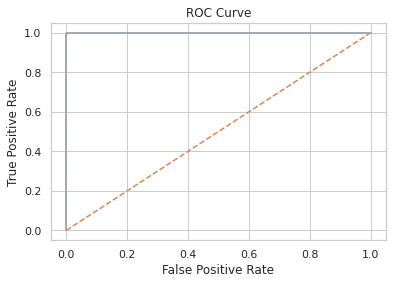




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.11    213605
   macro avg       0.50      0.55      0.10    213605
weighted avg       1.00      0.11      0.20    213605

-----------------------------------

Confusion Metrix: 
[[ 23835 189391]
 [     1    378]]
-----------------------------------

Accuracy Score
0.5545721403977154
-----------------------------------

ROC AUC Score
0.9712295428386747


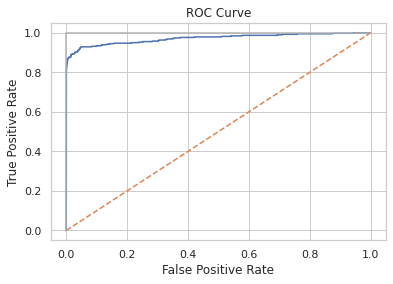




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20     71089
           1       0.00      0.97      0.00       113

    accuracy                           0.11     71202
   macro avg       0.50      0.54      0.10     71202
weighted avg       1.00      0.11      0.20     71202

-----------------------------------

Confusion Metrix: 
[[ 7901 63188]
 [    3   110]]
-----------------------------------

Accuracy Score
0.5422968491322793
-----------------------------------

ROC AUC Score
0.9383858473803933


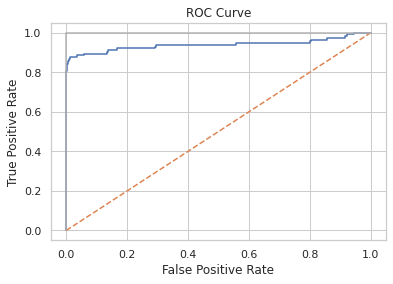

In [66]:
lr_model = CatBoostClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## LGBMClassifier

Undersampld data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      1.00      1.00       379

    accuracy                           1.00       758
   macro avg       1.00      1.00      1.00       758
weighted avg       1.00      1.00      1.00       758

-----------------------------------

Confusion Metrix: 
[[379   0]
 [  0 379]]
-----------------------------------

Accuracy Score
1.0
-----------------------------------

ROC AUC Score
1.0


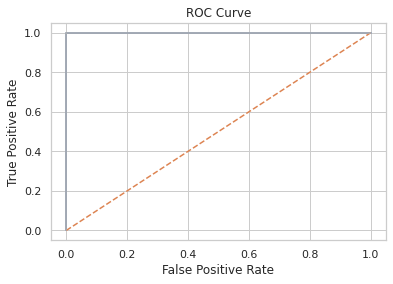




Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26    213226
           1       0.00      1.00      0.00       379

    accuracy                           0.15    213605
   macro avg       0.50      0.57      0.13    213605
weighted avg       1.00      0.15      0.26    213605

-----------------------------------

Confusion Metrix: 
[[ 31301 181925]
 [     0    379]]
-----------------------------------

Accuracy Score
0.5733986474444955
-----------------------------------

ROC AUC Score
0.9616629098705259


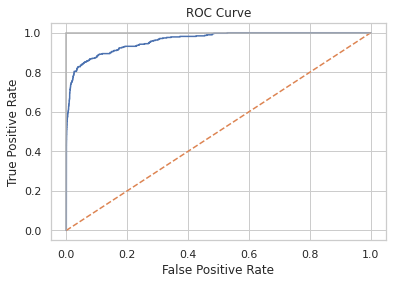




Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26     71089
           1       0.00      0.96      0.00       113

    accuracy                           0.15     71202
   macro avg       0.50      0.56      0.13     71202
weighted avg       1.00      0.15      0.25     71202

-----------------------------------

Confusion Metrix: 
[[10401 60688]
 [    4   109]]
-----------------------------------

Accuracy Score
0.5554556627694787
-----------------------------------

ROC AUC Score
0.9192718911368363


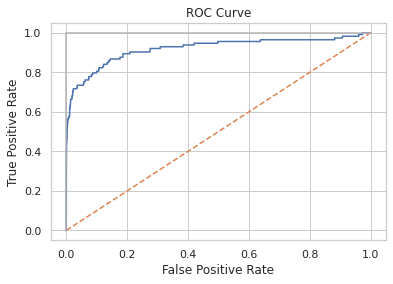

In [67]:
lr_model = LGBMClassifier()
lr_model.fit(X_us, y_us)

print("Undersampld data report")
print("---------------------------------------")
show_model_report(X_us,y_us,lr_model)
print('\n\n')
print("Train data report")
print("---------------------------------------")
show_model_report(X_train,y_train,lr_model)
print('\n\n')
print("Test data report")
print("---------------------------------------")
show_model_report(X_test,y_test,lr_model)

## Let's Try Oversampling

In [68]:
smk = SMOTETomek(random_state = 42)
X_ov_smk, y_ov_smk = smk.fit_sample(X_train, y_train)

In [69]:
print('Original dataset shape {}'.format(Counter(y_train)))
print('Undersampled dataset shape {}' .format(Counter(y_ov_smk)))

Original dataset shape Counter({0: 213226, 1: 379})
Undersampled dataset shape Counter({0: 213226, 1: 213226})


## LogisticRegression

Oversampled data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    213226
           1       0.97      0.92      0.95    213226

    accuracy                           0.95    426452
   macro avg       0.95      0.95      0.95    426452
weighted avg       0.95      0.95      0.95    426452

-----------------------------------

Confusion Metrix: 
[[207757   5469]
 [ 16297 196929]]
-----------------------------------

Accuracy Score
0.9489602581298715
-----------------------------------

ROC AUC Score
0.9906955454253554


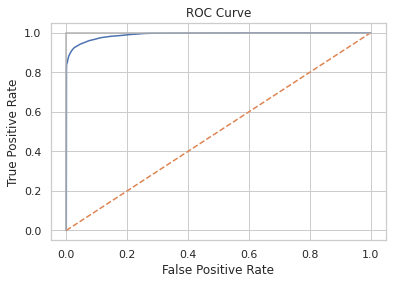

Train data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    213226
           1       0.06      0.93      0.11       379

    accuracy                           0.97    213605
   macro avg       0.53      0.95      0.55    213605
weighted avg       1.00      0.97      0.99    213605

-----------------------------------

Confusion Metrix: 
[[207757   5469]
 [    28    351]]
-----------------------------------

Accuracy Score
0.9502362649789968
-----------------------------------

ROC AUC Score
0.988185402251484


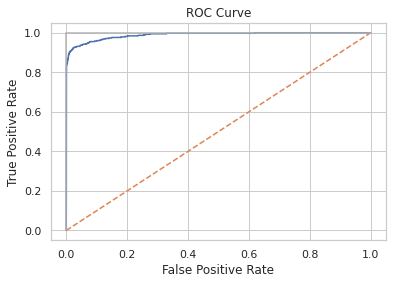

Test data report
---------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71089
           1       0.05      0.93      0.10       113

    accuracy                           0.97     71202
   macro avg       0.53      0.95      0.54     71202
weighted avg       1.00      0.97      0.99     71202

-----------------------------------

Confusion Metrix: 
[[69220  1869]
 [    8   105]]
-----------------------------------

Accuracy Score
0.9514562762345642
-----------------------------------

ROC AUC Score
0.9774666107809269


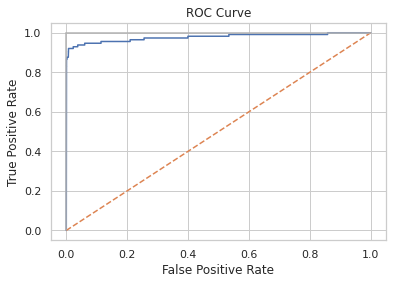

In [71]:
lr_model = LogisticRegression()
lr_model.fit(X_ov_smk, y_ov_smk)

print("Oversampled data report")
print("---------------------------------------")
show_model_report(X_ov_smk, y_ov_smk, lr_model)

print("Train data report")
print("---------------------------------------")
show_model_report(X_train, y_train, lr_model)

print("Test data report")
print("---------------------------------------")
show_model_report(X_test, y_test, lr_model)

**After Oversampling Recall for Test and Train data is .93 for Class Fraud**

### We can Further try other algorithms as well